# eCommerce store events data analysis

### 1. Customers clusterization

### About

This file contains behavior data for Nov 2019 from a large electronics commerce online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.

Data collected by Open CDP project.

https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Nov.csv

In [2]:
import numpy as np
import pandas as pd
import random
import datetime as dt

from pandasql import sqldf
import squarify

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sb
%matplotlib inline
import math

import warnings
warnings.filterwarnings('ignore')

In [58]:
df_file = './2019-Nov.csv'

{'tags': ["df_file = './2019-Nov.csv'"]}

In [3]:
df = pd.read_csv(df_file, sep=',')

In [4]:
df.shape

(67501979, 9)

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 24.4 GB


In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 4634.99 MB
Memory usage after optimization is: 2829.59 MB
Decreased by 39.0%


In [9]:
df.dtypes

event_time       category
event_type       category
product_id          int32
category_id         int64
category_code    category
brand            category
price             float32
user_id             int32
user_session     category
dtype: object

In [10]:
df.head(4)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.070007,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.649994,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.309999,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.869995,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f


In [67]:
df.isna().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

let's start with even type

In [57]:
df['event_type'].unique()

['view', 'cart', 'purchase']
Categories (3, object): ['cart', 'purchase', 'view']

In [59]:
df['event_type'].value_counts()

view        63556110
cart         3028930
purchase      916939
Name: event_type, dtype: int64

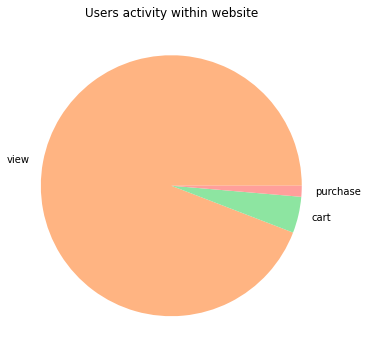

In [66]:
colors = sns.color_palette('pastel')[1:5]
plt.subplots(figsize=(12, 6))
plt.pie(df['event_type'].value_counts(), labels=df['event_type'].unique(), colors = colors)
plt.title('Users activity within website')
plt.show()

In [6]:
%%time
df['event_time']=pd.to_datetime(df['event_time']).dt.tz_convert(None)

CPU times: user 2min 33s, sys: 2.88 s, total: 2min 36s
Wall time: 2min 38s


In [69]:
df.head(4)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.070007,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.649994,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01,view,17302664,2053013553853497655,NaN,creed,28.309999,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.869995,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f


In [77]:
df['brand'].unique()

['xiaomi', 'janome', 'creed', 'lg', 'hp', ..., 'lauravalarosa', 'warrior', 'zmonday', 'pierrericaud', 'pjmasks']
Length: 4201
Categories (4200, object): ['a-case', 'a-derma', 'a-elita', 'a-mega', ..., 'zwilling', 'zwillingjahenckels', 'zx', 'zyxel']

Popular brends within the website

In [79]:
df['brand'].value_counts().head(10)

samsung    7889245
apple      6259379
xiaomi     4638062
huawei     1410126
lucente    1185075
lg         1096990
bosch       975059
oppo        811698
sony        798457
respect     765331
Name: brand, dtype: int64

### RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries.

RFM stands for the three dimensions:

    Recency – How recently did the customer purchase?
    Frequency – How often do they purchase?
    Monetary Value – How much do they spend?
    
source: https://en.wikipedia.org/wiki/RFM_(market_research)
    

In this method I'm trying to divide customers to categories, highlight the loyal and regular customers; identify customers who were loyal before in order to 'remind' about some new sales/services

In [7]:
purchase_df = df[df['event_type'] == 'purchase']
purchase_df.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
107,2019-11-01 00:00:41,purchase,13200605,2053013557192163841,furniture.bedroom.bed,NaN,566.299988,559368633,d6034fa2-41fb-4ac0-9051-55ea9fc9147a
168,2019-11-01 00:01:04,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.919998,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
707,2019-11-01 00:04:51,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.419998,562958505,0f039697-fedc-40fa-8830-39c1a024351d


since my notebook crushed sometimes, I need to make sure to work faster

In [21]:
#pip install pyarrow

In [8]:
import pyarrow.feather as feather
import os
os.makedirs('tmp', exist_ok=True)  # Make a temp dir for storing the feather file
feather.write_feather(purchase_df, './tmp/data')

In [64]:
purchase_df = pd.read_feather('./tmp/data')

In [65]:
purchase_df['event_time'].max()

Timestamp('2019-11-30 23:59:44')

In [66]:
recent_date = dt.datetime(2019,12,1)
recent_date

datetime.datetime(2019, 12, 1, 0, 0)

In [67]:
purchase_df=pd.DataFrame(purchase_df)
purchase_df['latest_purchase'] = recent_date - purchase_df.groupby('user_id')['event_time'].transform('max')
purchase_df['latest_purchase'].astype('timedelta64[D]')
purchase_df['latest_purchase']=purchase_df['latest_purchase'] / np.timedelta64(1, 'D')



In [71]:
purchase_df['money_spent'] = purchase_df.groupby('user_id')['price'].transform('sum')


In [69]:
purchase_df['number_purchase'] = purchase_df.groupby(["user_id"])["user_session"].transform("count")


In [72]:
purchase_df.drop(['user_session', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'event_time'], axis=1, inplace=True)


In [73]:
purchase_df.drop_duplicates(subset=None, keep="first", inplace=True)

In [74]:
purchase_df.shape

(441638, 4)

###  Segmentation using k-means

article about RFM analysis

https://www.optimove.com/resources/learning-center/rfm-segmentation

In [12]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [75]:
X = purchase_df.copy()
X.drop(['user_id'], axis=1, inplace=True)

In [76]:
#scaling for better performance
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [77]:
#dimension reduction for better k-means' performance
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(441638, 2)

In [78]:
#method for 2D data visualization
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

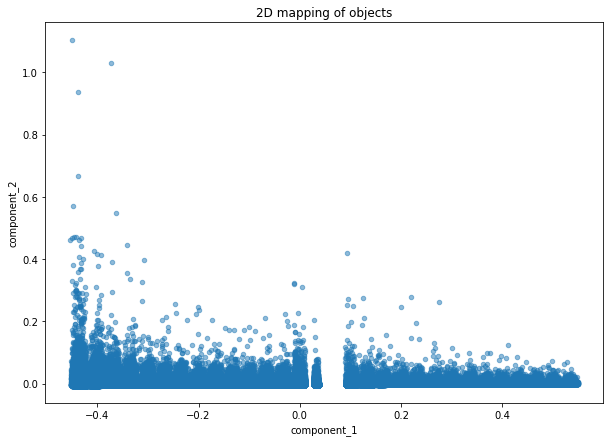

In [79]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_reduced = pd.DataFrame(data=X_reduced, columns=colnames)
components_X_reduced.head()

display_components_in_2D_space(components_X_reduced)

In [80]:
# I want 5 clusters like stated in the article
kmeans = KMeans(n_clusters=2, random_state=42)
labels_clast = kmeans.fit_predict(X_reduced)
labels_clast = pd.Series(labels_clast, name='clusters')

In [81]:
X_reduced = pd.DataFrame(X_reduced)

In [82]:
X_reduced.columns = ['component_1', 'component_2']

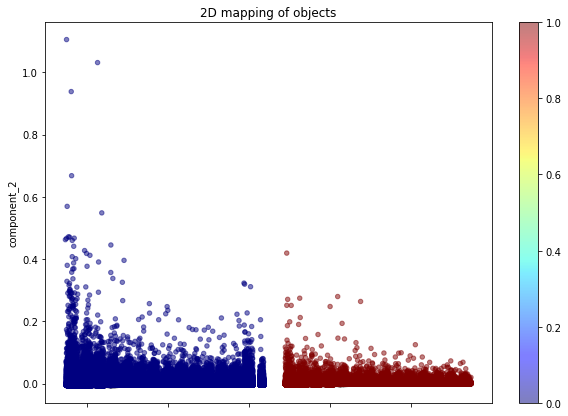

In [83]:
display_components_in_2D_space(X_reduced, labels=labels_clast)

In [84]:
df_pca_kmeans = pd.concat([purchase_df.reset_index(drop=True), pd.DataFrame(labels_clast)], axis=1)

In [85]:
df_pca_kmeans['clusters'].value_counts()

0    302610
1    139028
Name: clusters, dtype: int64

In [100]:
df_cluster1 = df_pca_kmeans[df_pca_kmeans['clusters'] == 1]
df_cluster1.describe()

,user_id,latest_purchase,money_spent,number_purchase,clusters
count,1.390280e+05,139028.000000,139028.000000,139028.00000,139028.0
mean,5.415137e+08,22.905989,436.859070,1.56111,1.0
std,2.139822e+07,3.963927,960.440735,1.72424,0.0
min,1.383403e+08,16.243322,1.000000,1.00000,1.0
25%,5.190496e+08,19.540969,79.527498,1.00000,1.0
50%,5.425536e+08,22.760272,190.460007,1.00000,1.0
75%,5.636645e+08,26.374447,458.250000,2.00000,1.0
max,5.715633e+08,29.999525,79311.000000,140.00000,1.0


In [87]:
df_cluster0 = df_pca_kmeans[df_pca_kmeans['clusters'] == 0]
df_cluster0.describe()

,user_id,latest_purchase,money_spent,number_purchase,clusters
count,3.026100e+05,302610.000000,302610.000000,302610.000000,302610.0
mean,5.422815e+08,9.230777,708.682861,2.312881,0.0
std,2.330902e+07,4.893439,1867.752319,3.827575,0.0
min,2.561642e+08,0.000185,0.770000,1.000000,0.0
25%,5.184092e+08,4.617642,125.849998,1.000000,0.0
50%,5.414780e+08,11.195984,275.114990,1.000000,0.0
75%,5.663365e+08,13.526736,716.135010,2.000000,0.0
max,5.799671e+08,14.644051,203986.062500,519.000000,0.0


Quite obvious that we can split customers to groups. In this case I decided to divide them into 2 groups. Group1 are people whose last purchase was quite a lot time ago, spent less money and not many purchases. Whilst, for Gruop0 is quite opposite. Last purchase mean is 9 days ago, spent in average $700, mean number of purchase is 2. Also, quantiles looks better

Now, let's try classic RFM method used in marketing.

Simple reminder that in kmeans we could change number of clusters as well

### RFM Segmentation

https://www.optimove.com/resources/learning-center/rfm-segmentation

The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer, which I already did

The second step is to divide the customer list into tiered groups for each of the three dimensions (R, F and M). Unless using specialized software, it’s recommended to divide the customers into four tiers for each dimension, such that each customer will be assigned to one tier in each dimension. This results in 64 distinct customer segments (4x4x4), into which customers will be segmented. 

The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [90]:
X = purchase_df.copy()
X.drop(['user_id'], axis=1, inplace=True)

In [91]:
X.quantile(q=[0.25,0.5,0.75])

,latest_purchase,money_spent,number_purchase
0.25,7.570278,108.599998,1.0
0.50,13.492106,246.039993,1.0
0.75,18.780564,616.919983,2.0


In [92]:
quartiles=X.quantile(q=[0.25,0.5,0.75]).to_dict()
quartiles

{'latest_purchase': {0.25: 7.570277777777778,
  0.5: 13.492106481481482,
  0.75: 18.78056423611111},
 'money_spent': {0.25: 108.5999984741211,
  0.5: 246.0399932861328,
  0.75: 616.9199829101562},
 'number_purchase': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0}}

In [93]:
# Create RFM Segments
## for Recency 

def R(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary 

def FM(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1    
    

In [94]:
#create RFM segmentation column
X['R_Quartile'] = X['latest_purchase'].apply(R, args=('latest_purchase',quartiles,))
X['F_Quartile'] = X['number_purchase'].apply(FM, args=('number_purchase',quartiles,))
X['M_Quartile'] = X['money_spent'].apply(FM, args=('money_spent',quartiles,))

X.head()

,latest_purchase,money_spent,number_purchase,R_Quartile,F_Quartile,M_Quartile
107,29.999525,566.299988,1,4,4,2
168,5.592928,546.520020,2,1,2,2
707,11.661528,1455.979980,12,2,1,1
811,28.312060,237.550003,2,4,2,3
939,29.985880,3421.599854,7,4,1,1


The third step is to select groups of customers to whom specific types of communications will be sent, based on the RFM segments in which they appear.

It is helpful to assign names to segments of interest:

**Best Customers** – This group consists of those customers who are found in R-Tier-1, F-Tier-1 and M-Tier-1, meaning that they transacted recently, do so often and spend more than other customers. A shortened notation for this segment is 1-1-1; we’ll use this notation going forward.

**High-spending New Customers** – This group consists of those customers in 1-4-1 and 1-4-2. These are customers who transacted only once, but very recently and they spent a lot.

**Lowest-Spending Active Loyal Customers** – This group consists of those customers in segments 1-1-3 and 1-1-4 (they transacted recently and do so often, but spend the least).

**Churned Best Customers** – This segment consists of those customers in groups 4-1-1, 4-1-2, 4-2-1 and 4-2-2 (they transacted frequently and spent a lot, but it’s been a long time since they’ve transacted).


In [95]:
# Define rfm_level function
def RFM_label(data):
    if data['R_Quartile'] == 1 and data['F_Quartile'] == 1 and data['M_Quartile'] == 1:
        return 'Best Customers'
    elif ((data['R_Quartile'] == 1 and data['F_Quartile'] == 4 and data['M_Quartile'] == 1) or
          (data['R_Quartile'] == 1 and data['F_Quartile'] == 4 and data['M_Quartile'] == 2)):
        return 'High-spending New Customers'
    elif ((data['R_Quartile'] == 1 and data['F_Quartile'] == 1 and data['M_Quartile'] == 3) or
          (data['R_Quartile'] == 1 and data['F_Quartile'] == 1 and data['M_Quartile'] == 4)):
        return 'Lowest-Spending Active Loyal Customers'
    elif ((data['R_Quartile'] == 4 and data['F_Quartile'] == 1 and data['M_Quartile'] == 1) or
          (data['R_Quartile'] == 4 and data['F_Quartile'] == 1 and data['M_Quartile'] == 2) or
          (data['R_Quartile'] == 4 and data['F_Quartile'] == 2 and data['M_Quartile'] == 1) or
          (data['R_Quartile'] == 4 and data['F_Quartile'] == 2 and data['M_Quartile'] == 2)):
        return 'Churned Best Customers'
    else:
        return 'others'
#Create RFM label for customer
X['RFM_label'] = X.apply(RFM_label, axis=1)
X.head()

,latest_purchase,money_spent,number_purchase,R_Quartile,F_Quartile,M_Quartile,RFM_label
107,29.999525,566.299988,1,4,4,2,others
168,5.592928,546.520020,2,1,2,2,others
707,11.661528,1455.979980,12,2,1,1,others
811,28.312060,237.550003,2,4,2,3,others
939,29.985880,3421.599854,7,4,1,1,Churned Best Customers


In [96]:
# Calculate average values for each RFM_Level, and return a size of each segment 
RFM_desc = X.groupby('RFM_label').agg({
    'latest_purchase': 'mean',
    'number_purchase': 'mean',
    'money_spent': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(RFM_desc)

                                       latest_purchase number_purchase  \
                                                  mean            mean   
RFM_label                                                                
Best Customers                                     2.9             8.4   
Churned Best Customers                            23.7             3.2   
High-spending New Customers                        3.5             1.0   
Lowest-Spending Active Loyal Customers             3.4             3.7   
others                                            14.2             1.7   

                                        money_spent          
                                               mean   count  
RFM_label                                                    
Best Customers                          3163.899902   23714  
Churned Best Customers                  1160.500000   19464  
High-spending New Customers              587.900024   17336  
Lowest-Spending Active Loyal Custom

In [98]:
RFM_desc

latest_purchase number_purchase  \
                                                  mean            mean   
RFM_label                                                                
Best Customers                                     2.9             8.4   
Churned Best Customers                            23.7             3.2   
High-spending New Customers                        3.5             1.0   
Lowest-Spending Active Loyal Customers             3.4             3.7   
others                                            14.2             1.7   

                                        money_spent          
                                               mean   count  
RFM_label                                                    
Best Customers                          3163.899902   23714  
Churned Best Customers                  1160.500000   19464  
High-spending New Customers              587.900024   17336  
Lowest-Spending Active Loyal Customers   146.000000    3294  
others                                   441.700012  377830

<AxesSubplot:ylabel='RFM_label'>

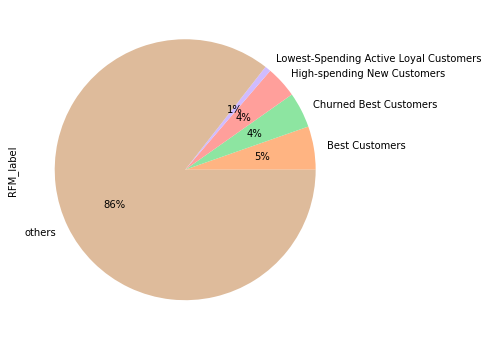

In [99]:
colors = sb.color_palette('pastel')[1:6]
plt.subplots(figsize=(12, 6))
X.RFM_label.str.get_dummies().sum().plot.pie(label='RFM_label', colors = colors, autopct='%1.0f%%')

#### Next task: classifiy 'others' as well:

In [43]:
#create RFM segmentation column
X['R_Quartile'] = X['latest_purchase'].apply(R, args=('latest_purchase',quartiles,))
X['F_Quartile'] = X['number_purchase'].apply(FM, args=('number_purchase',quartiles,))
X['M_Quartile'] = X['money_spent'].apply(FM, args=('money_spent',quartiles,))
X['RFM_segmentation'] = X.R_Quartile.map(str) \
                    + X.F_Quartile.map(str) \
                    + X.M_Quartile.map(str)
X['RFM_score'] = X.R_Quartile.map(int) \
                    + X.F_Quartile.map(int) \
                    + X.M_Quartile.map(int)
X.head()

,latest_purchase,money_spent,number_purchase,R_Quartile,F_Quartile,M_Quartile,RFM_label,RFM_segmentation,RFM_score
107,29.999525,566.299988,1,4,4,2,others,442,10
168,5.592928,546.520020,2,1,2,2,others,122,5
707,11.661528,1455.979980,12,2,1,1,others,211,4
811,28.312060,237.550003,2,4,2,3,others,423,9
939,29.985880,3421.599854,7,4,1,1,Churned Best Customers,411,6


In [44]:
# Define rfm_level function
def RFM_label_to_10(data):
    if data['RFM_score'] >= 10:
        return 'Lost'
    elif ((data['RFM_score'] >= 9) and (data['RFM_score'] < 10)):
        return 'Hibernating'
    elif ((data['RFM_score'] >= 8) and (data['RFM_score'] < 9)):
        return 'Can’t Lose Them'
    elif ((data['RFM_score'] >= 7) and (data['RFM_score'] < 8)):
        return 'About To Sleep'
    elif ((data['RFM_score'] >= 6) and (data['RFM_score'] < 7)):
        return 'Promising'
    elif ((data['RFM_score'] >= 5) and (data['RFM_score'] < 6)):
        return 'Potential Loyalist'
    elif ((data['RFM_score'] >= 4) and (data['RFM_score'] < 5)):
        return 'Loyal Customers'
    else:
        return 'Champions'
#Create RFM label for customer
X['RFM_label'] = X.apply(RFM_label_to_10, axis=1)
X.head()

,latest_purchase,money_spent,number_purchase,R_Quartile,F_Quartile,M_Quartile,RFM_label,RFM_segmentation,RFM_score
107,29.999525,566.299988,1,4,4,2,Lost,442,10
168,5.592928,546.520020,2,1,2,2,Potential Loyalist,122,5
707,11.661528,1455.979980,12,2,1,1,Loyal Customers,211,4
811,28.312060,237.550003,2,4,2,3,Hibernating,423,9
939,29.985880,3421.599854,7,4,1,1,Promising,411,6


In [51]:
# Calculate average values for each RFM_Level, and return a size of each segment 
RFM_desc = X.groupby('RFM_label').agg({
    'latest_purchase': 'mean',
    'number_purchase': 'mean',
    'money_spent': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(RFM_desc)

                   latest_purchase number_purchase  money_spent        
                              mean            mean         mean   count
RFM_label                                                              
About To Sleep                11.6             1.7   528.799988   44791
Can’t Lose Them               11.7             1.3   396.799988   55724
Champions                      2.9             8.4  3163.899902   23714
Hibernating                   12.4             1.1   284.000000   73548
Lost                          19.5             1.0   129.100006  144109
Loyal Customers                7.7             4.5  1603.699951   27689
Potential Loyalist             9.9             3.4  1096.900024   33089
Promising                     12.0             2.6   877.099976   38974


<AxesSubplot:ylabel='RFM_label'>

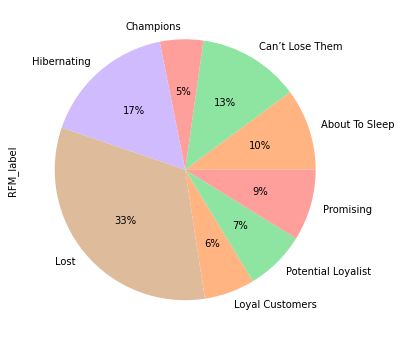

In [56]:
colors = sb.color_palette('pastel')[1:6]
plt.subplots(figsize=(12, 6))
X.RFM_label.str.get_dummies().sum().plot.pie(label='RFM_label', colors = colors, autopct='%1.0f%%')

Now that we've identified our customer categories, we can decide how to approach or deal with each customer:

    Champions : Reward them. Can be early adopters of new products. Will promote your brand. Most likely to send referrals.
    Loyal Customer : Upsell higher value products. Ask for reviews.
    Potential Loyalist : Offer membership / loyalty program. Keep them engaged. Offer personalised recommendations.
    Promising : Offer coupons. Bring them back to the platform and keep them engaged. Offer personalised recommendations.
    About to Sleep : Win them back via renewals or newer products, don’t lose them to competition. Talk to them if necessary. Spend time on highest possible personalisation.
    Can't Lose Them : Provide helpful resources on the site. Send personalised emails.
        Hibernating : Make subject lines of emails very personalised. Revive their interest by a specific discount on a specific product.
    Lost : Revive interest with reach out campaign. Ignore otherwise.


Link to the article:

https://documentation.bloomreach.com/engagement/docs/rfm-segmentation